In [2]:
import time
import os, fnmatch
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import numpy as np
import numpy.random as rand
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
1

/home/arjung2/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


1

In [3]:
# create a list, result, of all file names
def find(pattern, path):
    result = []
    for root, dirs, files in os.walk(path):
        for name in files:
            if fnmatch.fnmatch(name, pattern):
                result.append(os.path.join(root, name))
    return result

path = "WebFaces/CASIA-WebFace"

directory_list = list()
for root, dirs, files in os.walk(path, topdown=False):
    for name in dirs:
        directory_list.append(os.path.join(root, name))
        
print("Number of Unique People: " + str(len(dirs)))

Number of Unique People: 10575


In [4]:
# directory_list: array of folder paths (WebFaces/CASIA-WebFace/0000045)
#           dirs: array of folder names (0000045)

num_imgs = []
for folder in directory_list:
    result = find('*.jpg', folder)
    num_imgs.append(len(result))
    
print("Number of Images of First Person: " + str(num_imgs[0]))

Number of Images of First Person: 15


An example image:
Person Number: 5902
Image Number: 9


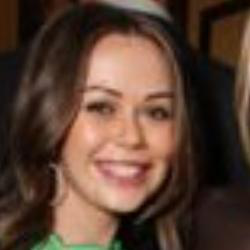

In [5]:
# print example image
print("An example image:")
i = rand.randint(0, len(dirs))
j = rand.randint(1, num_imgs[i] + 1)

if j < 10:
    string = "/00" + str(j) + ".jpg"
elif j < 100: 
    string = "/0" + str(j) + ".jpg"
elif j < 1000:
    string = "/" + str(j) + ".jpg"
    
print("Person Number: " + str(i))
print("Image Number: " + str(j))

img = load_img(directory_list[i] + string)
display(img)

In [6]:
test_size = 1000

# Create training set 

def training_set(train_size):
    x_train_left = []
    x_train_right = []
    y_train = []

    print("Generating Pairs:")
    
    # add dissimilar pairs
    count = 0
    while count < int(train_size / 2):

        while True:
            rand_1 = rand.randint(0, len(dirs) - test_size)
            rand_2 = rand.randint(0, len(dirs) - test_size)

            if rand_1 != rand_2:
                break

        rand_3 = rand.randint(1, num_imgs[rand_1] + 1)
        rand_4 = rand.randint(1, num_imgs[rand_2] + 1)
        
        if rand_3 < 10:
            img_one = directory_list[rand_1] + "/00" + str(rand_3) + ".jpg"
        elif rand_3 < 100: 
            img_one = directory_list[rand_1] + "/0" + str(rand_3) + ".jpg"
        elif rand_3 < 1000:
            img_one = directory_list[rand_1] + "/" + str(rand_3) + ".jpg"
            
        if rand_4 < 10:
            img_two = directory_list[rand_2] + "/00" + str(rand_4) + ".jpg"
        elif rand_4 < 100: 
            img_two = directory_list[rand_2] + "/0" + str(rand_4) + ".jpg"
        elif rand_4 < 1000:
            img_two = directory_list[rand_2] + "/" + str(rand_4) + ".jpg"
                
        left = load_img(img_one)
        left = img_to_array(left)
        # normalize image
        left = (left - 127.5) / 127.5
        x_train_left.append(left)

        right = load_img(img_two)
        right = img_to_array(right)
        # normalize image
        right = (right - 127.5) / 127.5
        x_train_right.append(right)
        
        y_train.append(1)

        count += 1

        if count % 100 == 0:
            print(".", end="")

    print("\n")

    # add similar pairs
    count = 0
    while count < int(train_size / 2):

        while True:
            rand_1 = rand.randint(0, len(dirs) - test_size)
            
            rand_2 = rand.randint(1, num_imgs[rand_1] + 1)
            rand_3 = rand.randint(1, num_imgs[rand_1] + 1)

            if rand_2 != rand_3:
                break
        
        if rand_2 < 10:
            img_one = directory_list[rand_1] + "/00" + str(rand_2) + ".jpg"
        elif rand_2 < 100: 
            img_one = directory_list[rand_1] + "/0" + str(rand_2) + ".jpg"
        elif rand_2 < 1000:
            img_one = directory_list[rand_1] + "/" + str(rand_2) + ".jpg"
            
        if rand_3 < 10:
            img_two = directory_list[rand_1] + "/00" + str(rand_3) + ".jpg"
        elif rand_3 < 100: 
            img_two = directory_list[rand_1] + "/0" + str(rand_3) + ".jpg"
        elif rand_3 < 1000:
            img_two = directory_list[rand_1] + "/" + str(rand_3) + ".jpg"
                
        left = load_img(img_one)
        left = img_to_array(left)
        # normalize image
        left = (left - 127.5) / 127.5
        x_train_left.append(left)

        right = load_img(img_two)
        right = img_to_array(right)
        # normalize image
        right = (right - 127.5) / 127.5
        x_train_right.append(right)
        
        y_train.append(0)

        count += 1

        if count % 100 == 0:
            print("_", end="")

    print("\n")

    # convert x_train arrays from Python lists to NumPy arrays
    x_train_left = np.array(x_train_left)
    x_train_right = np.array(x_train_right)
    
    x_train = [x_train_left, x_train_right]

    # create y_train
    # y_train = np.ones(train_size)
    # y_train[int(train_size / 2):] = 0
    
    return x_train, y_train

In [7]:
# Create test set
x_test_left = []
x_test_right = []
y_test = []

print("Generating Pairs:")

# add dissimilar pairs
count = 0
while count < int(test_size / 2):

    while True:
        rand_1 = rand.randint(len(dirs) - 1000, len(dirs))
        rand_2 = rand.randint(len(dirs) - 1000, len(dirs))

        if rand_1 != rand_2:
            break

    rand_3 = rand.randint(1, num_imgs[rand_1] + 1)
    rand_4 = rand.randint(1, num_imgs[rand_2] + 1)

    if rand_3 < 10:
        img_one = directory_list[rand_1] + "/00" + str(rand_3) + ".jpg"
    elif rand_3 < 100: 
        img_one = directory_list[rand_1] + "/0" + str(rand_3) + ".jpg"
    elif rand_3 < 1000:
        img_one = directory_list[rand_1] + "/" + str(rand_3) + ".jpg"

    if rand_4 < 10:
        img_two = directory_list[rand_2] + "/00" + str(rand_4) + ".jpg"
    elif rand_4 < 100: 
        img_two = directory_list[rand_2] + "/0" + str(rand_4) + ".jpg"
    elif rand_4 < 1000:
        img_two = directory_list[rand_2] + "/" + str(rand_4) + ".jpg"

    left = load_img(img_one)
    left = img_to_array(left)
    # normalize image
    left = (left - 127.5) / 127.5
    x_test_left.append(left)

    right = load_img(img_two)
    right = img_to_array(right)
    # normalize image
    right = (right - 127.5) / 127.5
    x_test_right.append(right)

    y_test.append(1)

    count += 1

    if count % 100 == 0:
        print(".", end="")

print("\n")

# add similar pairs
count = 0
while count < int(test_size / 2):

    while True:
        rand_1 = rand.randint(len(dirs) - 1000, len(dirs))

        rand_2 = rand.randint(1, num_imgs[rand_1] + 1)
        rand_3 = rand.randint(1, num_imgs[rand_1] + 1)

        if rand_2 != rand_3:
            break

    if rand_2 < 10:
        img_one = directory_list[rand_1] + "/00" + str(rand_2) + ".jpg"
    elif rand_2 < 100: 
        img_one = directory_list[rand_1] + "/0" + str(rand_2) + ".jpg"
    elif rand_2 < 1000:
        img_one = directory_list[rand_1] + "/" + str(rand_2) + ".jpg"

    if rand_3 < 10:
        img_two = directory_list[rand_1] + "/00" + str(rand_3) + ".jpg"
    elif rand_3 < 100: 
        img_two = directory_list[rand_1] + "/0" + str(rand_3) + ".jpg"
    elif rand_3 < 1000:
        img_two = directory_list[rand_1] + "/" + str(rand_3) + ".jpg"

    left = load_img(img_one)
    left = img_to_array(left)
    # normalize image
    left = (left - 127.5) / 127.5
    x_test_left.append(left)

    right = load_img(img_two)
    right = img_to_array(right)
    # normalize image
    right = (right - 127.5) / 127.5
    x_test_right.append(right)

    y_test.append(0)

    count += 1

    if count % 100 == 0:
        print("_", end="")

# print("\n")

# convert x_test arrays from Python lists to NumPy arrays
x_test_left = np.array(x_test_left)
x_test_right = np.array(x_test_right)

x_test = [x_test_left, x_test_right]

Generating Pairs:
.....

_____

In [8]:
# create model
input_shape = (250, 250, 3)
left_input = Input(input_shape)
right_input = Input(input_shape)

# convnet for each siamese leg
convnet = Sequential()

convnet.add(Conv2D(64,(3,3),activation='relu',input_shape=input_shape))
convnet.add(MaxPooling2D()) #64x241x241 -> 64x120x120

convnet.add(Conv2D(128,(4,4),activation='relu', kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D()) #128x114x114 -> 128x57x57

convnet.add(Conv2D(256,(5,5),activation='relu',kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D()) #256x54x54 -> 256x27x27

convnet.add(Conv2D(512,(4,4),activation='relu',kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D()) #512x21x21 -> 512x10x10

convnet.add(Conv2D(1024,(3,3),activation='relu'))

convnet.add(Flatten())

convnet.add(Dense(128,activation="sigmoid",kernel_regularizer=l2(1e-3)))

# call the convnet Sequential model on each of the input tensors so params will be shared
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)

# layer to merge two encoded inputs with the l1 distance between them
L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))

# call this layer on list of two input tensors.
L1_distance = L1_layer([encoded_l, encoded_r])
prediction = Dense(1,activation='sigmoid')(L1_distance)
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

def contrastive_loss(y_true, y_pred):
    margin = 0
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

# siamese_net.compile(loss=contrastive_loss, optimizer=Adam(0.000006))
siamese_net.compile(loss="binary_crossentropy", optimizer=Adam(0.000006))

Generating Pairs:
...........................................................................

___________________________________________________________________________

Epoch 1/1
15000/15000 [==============================] - 207s 14ms/step - loss: 0.5440
Validation Set Accuracy: 0.781


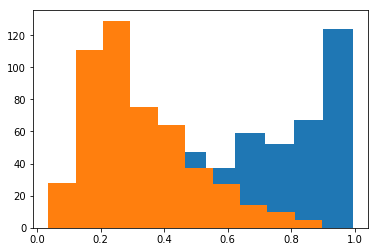

Training Set Accuracy: 0.8338666666666666


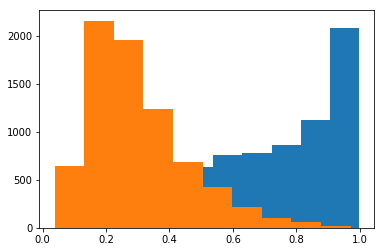

Generating Pairs:
...........................................................................

___________________________________________________________________________

Epoch 1/1
15000/15000 [==============================] - 221s 15ms/step - loss: 0.5472
Validation Set Accuracy: 0.775


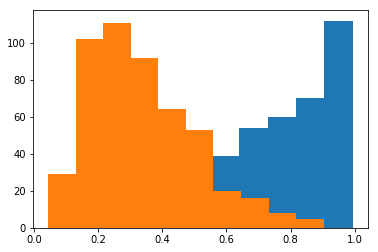

Training Set Accuracy: 0.8272


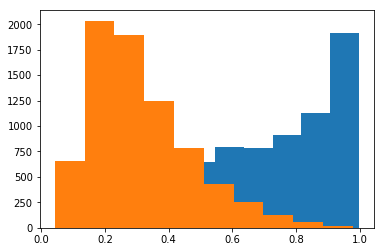

Generating Pairs:
...........................................................................

___________________________________________________________________________

Epoch 1/1
15000/15000 [==============================] - 219s 15ms/step - loss: 0.5335
Validation Set Accuracy: 0.782


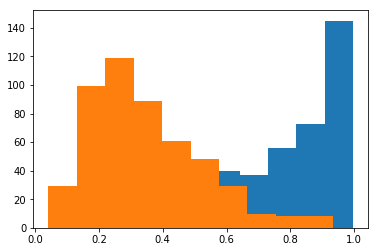

Training Set Accuracy: 0.835


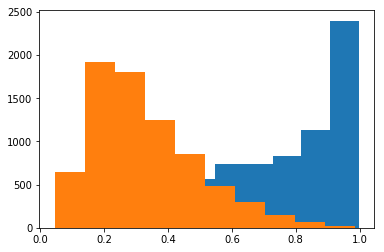

Generating Pairs:
...........................................................................

___________________________________________________________________________

Epoch 1/1
15000/15000 [==============================] - 221s 15ms/step - loss: 0.5366
Validation Set Accuracy: 0.78


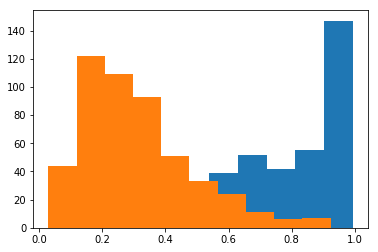

Training Set Accuracy: 0.8336666666666667


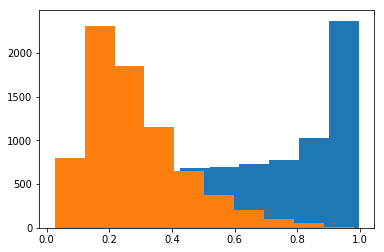

Generating Pairs:
...........................................................................

___________________________________________________________________________

Epoch 1/1
15000/15000 [==============================] - 223s 15ms/step - loss: 0.5299
Validation Set Accuracy: 0.774


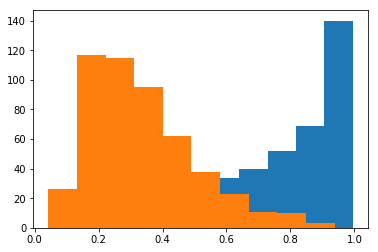

Training Set Accuracy: 0.8428


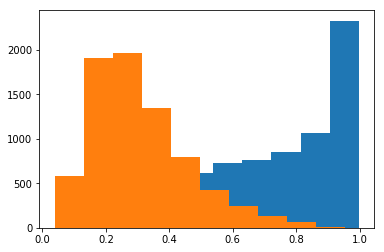

Generating Pairs:
...........................................................................

___________________________________________________________________________

Epoch 1/1
15000/15000 [==============================] - 222s 15ms/step - loss: 0.5353
Validation Set Accuracy: 0.782


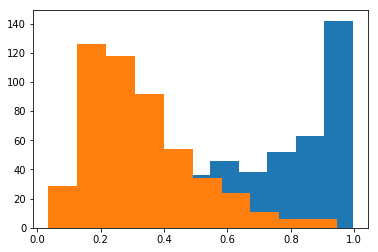

Training Set Accuracy: 0.836


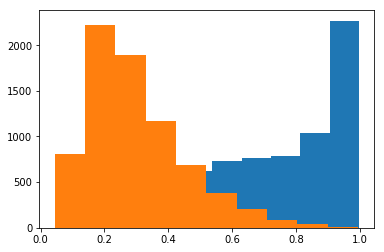

Generating Pairs:
...........................................................................

___________________________________________________________________________

Epoch 1/1
15000/15000 [==============================] - 221s 15ms/step - loss: 0.5352
Validation Set Accuracy: 0.77


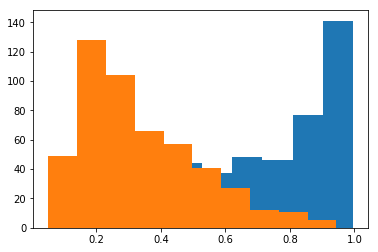

Training Set Accuracy: 0.8358


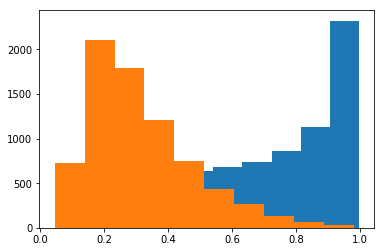

Generating Pairs:
...........................................................................

___________________________________________________________________________

Epoch 1/1
15000/15000 [==============================] - 222s 15ms/step - loss: 0.5387
Validation Set Accuracy: 0.776


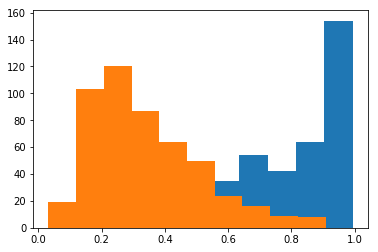

Training Set Accuracy: 0.8376


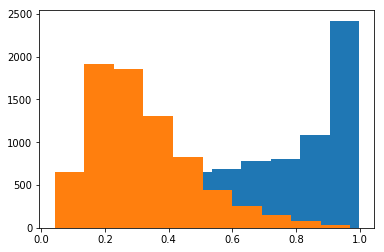

59.559201836586


In [9]:
global_start_time = time.time()

siamese_net.load_weights('siamese_weights_casia.h5')

for _ in range(8):
    x_train, y_train = training_set(15000)
    # x_train = [x_train[0][6000:], x_train[1][6000:]]
    siamese_net.fit([x_train[0], x_train[1]], 
                    y_train,
                    batch_size=4, 
                    epochs=1)
    
    # print("\n")
    # print("VALIDATION SET:")
    
    predicted = siamese_net.predict([x_test_left, x_test_right])

    count = 0
    for i in range(len(predicted)):
        if i < 500 and predicted[i] > 0.5:
            count += 1
        if i >= 500 and predicted[i] < 0.5:
            count += 1
            
    print("Validation Set Accuracy: " + str(float(count) / len(predicted)))
        
    plt.hist(predicted[:500])
    plt.hist(predicted[500:])
    plt.show()
    
    # print("\n")
    # print("TRAINING SET:")
    
    predicted_train = siamese_net.predict([x_train[0], x_train[1]])
    
    count = 0
    for i in range(len(predicted_train)):
        if i < 7500 and predicted_train[i] > 0.5:
            count += 1
        if i >= 7500 and predicted_train[i] < 0.5:
            count += 1
            
    print("Training Set Accuracy: " + str(float(count) / len(predicted_train)))
        
    plt.hist(predicted_train[:7500])
    plt.hist(predicted_train[7500:])
    plt.show()
    
    siamese_net.save_weights('siamese_weights_casia.h5')

# plt.hist(predicted[:500])
# plt.hist(predicted[500:])
# plt.show()

siamese_net.save_weights('siamese_weights_casia.h5')

print((time.time() - global_start_time) / 60)

In [10]:
# siamese_net.load_weights('siamese_weights.h5')

predicted = siamese_net.predict([x_test_left, x_test_right])

1000
Average of Dissimilar Images: 0.6914229753017426
Average of Similar    Images: 0.34021116818487646



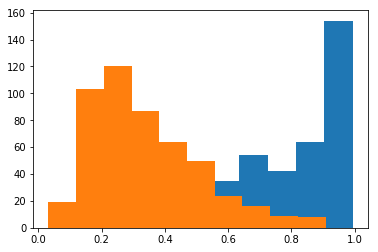

Predicted to be Similar: [0.23118468]
Actual: Similar


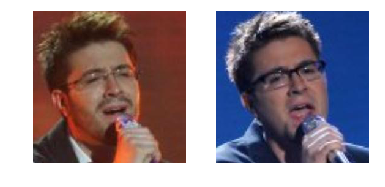

Predicted to be Different: [0.96613944]
Actual: Different


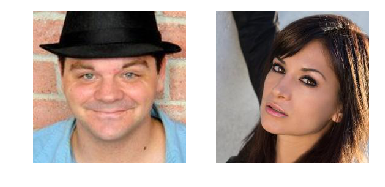

Predicted to be Different: [0.8301504]
Actual: Similar


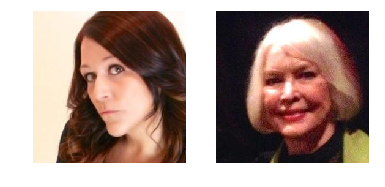

Predicted to be Different: [0.7956494]
Actual: Different


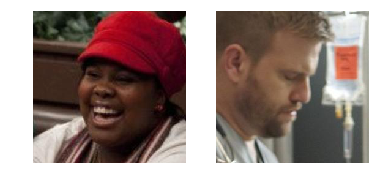

Predicted to be Similar: [0.23838684]
Actual: Similar


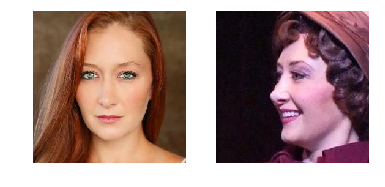

Predicted to be Different: [0.6683989]
Actual: Similar


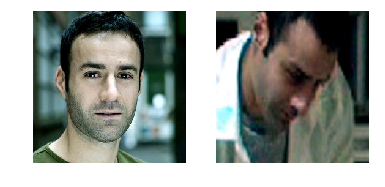

Predicted to be Similar: [0.45364484]
Actual: Different


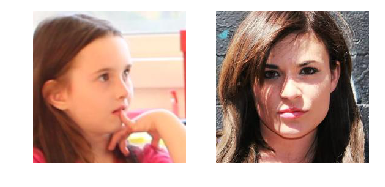

Predicted to be Different: [0.8652789]
Actual: Different


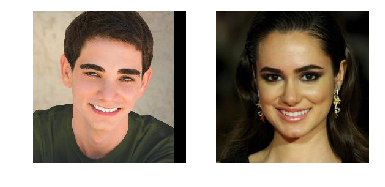

Predicted to be Similar: [0.20918371]
Actual: Similar


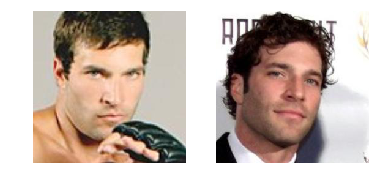

Predicted to be Different: [0.8568607]
Actual: Similar


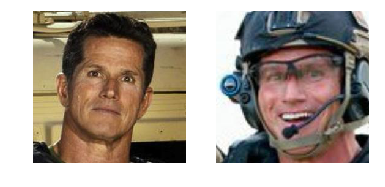

In [11]:
print(len(predicted))
count = 0
sum_one = 0
sum_zero = 0
for num in predicted:
    if count < 500:
        sum_one += num[0]
    else:
        sum_zero += num[0]
        
    count += 1
        
print("Average of Dissimilar Images: " + str(sum_one / 500.0))
print("Average of Similar    Images: " + str(sum_zero / 500.0) + "\n")
# print("Predicted Array: ")
# print(predicted)

plt.hist(predicted[:500])
plt.hist(predicted[500:])
plt.show()

for _ in range(10):
    k = rand.randint(0, len(predicted))
    
    if predicted[k] < 0.5:
        print("Predicted to be Similar: " + str(predicted[k]))
    else:
        print("Predicted to be Different: " + str(predicted[k]))
        
    if k < 500:
        print("Actual: Different")
    else:
        print("Actual: Similar")
    
    display_left = (x_test_left[k] * 127.5) + 127.5
    display_left = array_to_img(display_left)
    display_right = (x_test_right[k] * 127.5) + 127.5
    display_right = array_to_img(display_right)
    f = plt.figure()
    f.add_subplot(1, 2, 1)
    plt.imshow(display_left)
    plt.axis('off')
    f.add_subplot(1, 2, 2)
    plt.imshow(display_right)
    plt.axis('off')
    plt.show()


Predicted to be Similar
[0.4784489]


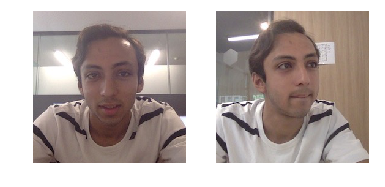

In [12]:
custom_left = []
left = load_img("pic1.jpg")
left = img_to_array(left)
left = (left - 127.5) / 127.5
custom_left.append(left)

custom_right = []
right = load_img("pic2.jpg")
right = img_to_array(right)
right = (right - 127.5) / 127.5
custom_right.append(right)

custom_left = np.array(custom_left)
custom_right = np.array(custom_right)

predicted = siamese_net.predict([custom_left, custom_right])

if predicted[0] < 0.5:
    print("Predicted to be Similar")
    print(predicted[0])
else:
    print("Predicted to be Different")
    print(predicted[0])

display_left = (custom_left[0] * 127.5) + 127.5
display_left = array_to_img(display_left)
display_right = (custom_right[0] * 127.5) + 127.5
display_right = array_to_img(display_right)
f = plt.figure()
f.add_subplot(1, 2, 1)
plt.imshow(display_left)
plt.axis('off')
f.add_subplot(1, 2, 2)
plt.imshow(display_right)
plt.axis('off')
plt.show()

In [13]:
arr = []
for i in range(3, 18):
    name = "pic" + str(i) + ".jpg"
    img = load_img(name)
    img = img_to_array(img)
    img = (img - 127.5) / 127.5
    arr.append(img)
    
size = 100
left = []
right = []
for i in range(size):
    a = rand.randint(0, len(arr))
    b = rand.randint(0, len(arr))
    
    left.append(arr[a])
    right.append(arr[b])

y = np.zeros(size)    
    
siamese_net.fit([left, right], 
                y,
                batch_size=4, 
                epochs=20)
    

Epoch 1/20
100/100 [==============================] - 1s 13ms/step - loss: 0.4367
Epoch 2/20
100/100 [==============================] - 2s 15ms/step - loss: 0.2405
Epoch 3/20
100/100 [==============================] - 2s 15ms/step - loss: 0.1738
Epoch 4/20
100/100 [==============================] - 2s 15ms/step - loss: 0.1454
Epoch 5/20
100/100 [==============================] - 2s 15ms/step - loss: 0.1300
Epoch 6/20
100/100 [==============================] - 2s 15ms/step - loss: 0.1209
Epoch 7/20
100/100 [==============================] - 2s 15ms/step - loss: 0.1150
Epoch 8/20
100/100 [==============================] - 2s 17ms/step - loss: 0.1111
Epoch 9/20
100/100 [==============================] - 2s 16ms/step - loss: 0.1080
Epoch 10/20
100/100 [==============================] - 2s 16ms/step - loss: 0.1057
Epoch 11/20
100/100 [==============================] - 2s 16ms/step - loss: 0.1037
Epoch 12/20
100/100 [==============================] - 2s 16ms/step - loss: 0.1021
Epoch 13/20
1

Predicted to be Similar
[0.0917526]


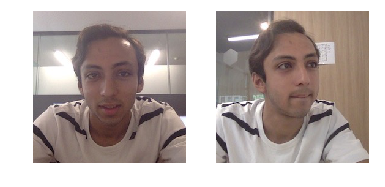

In [14]:
custom_left = []
left = load_img("pic1.jpg")
left = img_to_array(left)
left = (left - 127.5) / 127.5
custom_left.append(left)

custom_right = []
right = load_img("pic2.jpg")
right = img_to_array(right)
right = (right - 127.5) / 127.5
custom_right.append(right)

custom_left = np.array(custom_left)
custom_right = np.array(custom_right)

predicted = siamese_net.predict([custom_left, custom_right])

if predicted[0] < 0.5:
    print("Predicted to be Similar")
    print(predicted[0])
else:
    print("Predicted to be Different")
    print(predicted[0])

display_left = (custom_left[0] * 127.5) + 127.5
display_left = array_to_img(display_left)
display_right = (custom_right[0] * 127.5) + 127.5
display_right = array_to_img(display_right)
f = plt.figure()
f.add_subplot(1, 2, 1)
plt.imshow(display_left)
plt.axis('off')
f.add_subplot(1, 2, 2)
plt.imshow(display_right)
plt.axis('off')
plt.show()

In [15]:
# Things to try:
# - Contrastive Loss
# - Retrain and observe at which epoch Train and Test set diverge (detect overfitting)
# - Microsoft dataset
# - Training with 10 images of me and then testing on above images
# - Face Detection and Alignment